In [1]:
from torch import nn
import torch, gym, gym_unbalanced_disk, time, gym.wrappers
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
import os

In [2]:
class Qfunction(nn.Module):
    def __init__(self, env):
        super(Qfunction,self).__init__()
        self.lay1 = nn.Linear(env.observation_space.shape[0], 40)
        self.F1 =  nn.Tanh() #a)
        self.lay2 = nn.Linear(40,env.action_space.n)
    
    def forward(self, obs):
        return self.lay2(self.F1(self.lay1(obs)))

In [3]:
def show(Q,env):
    with torch.no_grad():
        #you can use Qfun(obs) as a shorthand for the q function.
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() #convert x to torch.tensor -> put in the Q function -> back to numpy
        try:
            obs = env.reset() #b)
            env.render() #b)
            time.sleep(1) #b)
            while True: #b)
                action = np.argmax(Qfun(obs)) #b)
                obs, reward, done, info = env.step(action) #b)
                time.sleep(1/60) #b)
                env.render() #b)
                print(env.u)
                if done: #b)
                    time.sleep(0.5)  #b)
                    break  #b)
        finally: #this will always run even when an error occurs
            env.close()

In [4]:
def rollout(Q, env, epsilon=0.1, N_rollout=10_000): 
    #save the following (use .append)
    Start_state = [] #hold an array of (x_t)
    Actions = [] #hold an array of (u_t)
    Rewards = [] #hold an array of (r_{t+1})
    End_state = [] #hold an array of (x_{t+1})
    Terminal = [] #hold an array of (terminal_{t+1})
    # Qfun( a numpy array of the obs) -> a numpy array of Q values
    Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() 
    with torch.no_grad():
        
        obs = env.reset() #c)
        for i in range(N_rollout): #c)
            if np.random.uniform()>epsilon: #c)
                Qnow = Qfun(obs) #c)
                action = np.argmax(Qnow) #c)
            else: #c)
                action = env.action_space.sample() #c)
            Start_state.append(obs) #c)
            Actions.append(action) #c)

            obs_next, reward, done, info = env.step(action) #c)
            terminal = done and not info.get('TimeLimit.truncated', False) #c)

            Terminal.append(terminal) #c)
            Rewards.append(reward) #c)
            End_state.append(obs_next) #c)

            if done: #c)
                obs = env.reset() #c)
            else: #c)
                obs = obs_next #c)
                
    #error checking:
    assert len(Start_state)==len(Actions)==len(Rewards)==len(End_state)==len(Terminal), f'error in lengths: {len(Start_state)}=={len(Actions)}=={len(Rewards)}=={len(End_state)}=={len(Dones)}'
    return np.array(Start_state), np.array(Actions), np.array(Rewards), np.array(End_state), np.array(Terminal).astype(int)

In [5]:
def eval_Q(Q,env):
    with torch.no_grad():
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
        rewards_acc = 0 #d)
        obs = env.reset() #d)
        while True: #d)
            action = np.argmax(Qfun(obs)) #d)
            obs, reward, done, info = env.step(action) #d)
            rewards_acc += reward #d)
            if done: #d)
                return rewards_acc #d)

In [6]:
def DQN_rollout(Q, optimizer, env, gamma=0.98, use_target_net=False, N_iterations=21, N_rollout=20000, \
                N_epochs=10, batch_size=32, N_evals=10, target_net_update_feq=100):
    best = -float('inf')
    torch.save(Q.state_dict(),'Q-checkpoint')
    try:
        for iteration in range(N_iterations):
            epsilon = 1.0 - iteration/(N_iterations-1) #e=) 1.
            print(f'rollout iteration {iteration} with epsilon={epsilon:.2%}...')
            
            #2. rollout
            Start_state, Actions, Rewards, End_state, Dones = rollout(Q, env, epsilon=epsilon, N_rollout=N_rollout) #e) 2.
            
            #Data conversion, no changes required
            convert = lambda x: [torch.tensor(xi,dtype=torch.float32) for xi in x]
            Start_state, Rewards, End_state, Dones = convert([Start_state, Rewards, End_state, Dones])
            Actions = Actions.astype(int)

            print('starting training on rollout information...')
            t = 0
            for epoch in range(N_epochs): 
                for i in range(batch_size,len(Start_state)+1,batch_size): 
                    if t%target_net_update_feq==0:
                        Qtarget = deepcopy(Q) #g)
                        pass
                    t += 1
                    
                    Start_state_batch, Actions_batch, Rewards_batch, End_state_batch, Dones_batch = [d[i-batch_size:i] for d in [Start_state, Actions, Rewards, End_state, Dones]] #e=) 3.
                    
                    with torch.no_grad(): #3.
                        if use_target_net:
                            pass
                            maxQ = torch.max(Qtarget(End_state_batch),dim=1)[0] #g)
                        else:
                            maxQ = torch.max(Q(End_state_batch),dim=1)[0] #e=) 3.
                    
                    action_index = np.stack((np.arange(batch_size),Actions_batch),axis=0)
                    Qnow = Q(Start_state_batch)[action_index] #Q(x_t,u_t) is given
                    
                    Loss = torch.mean((Rewards_batch + gamma*maxQ*(1-Dones_batch) - Qnow)**2) #e) 3.
                    optimizer.zero_grad() #e) 3.
                    Loss.backward() #e) 3.
                    optimizer.step() #e) 3.
                
                score = np.mean([eval_Q(Q,env) for i in range(N_evals)]) #e=) 3.
                
                print(f'iteration={iteration} epoch={epoch} Average Reward per episode:',score)
                if score>best:
                    best = score
                    print('################################# \n new best',best,'saving Q... \n#################################')
                    torch.save(Q.state_dict(),'Q-checkpoint')
            
            print('loading best result')
            Q.load_state_dict(torch.load('Q-checkpoint'))
    finally: #this will always run even when using the a KeyBoard Interrupt. 
        print('loading best result')
        Q.load_state_dict(torch.load('Q-checkpoint'))

In [7]:
max_episode_steps = 300
env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=3.)
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)

target_angle = np.pi # target set to be balanced on top
# reward_function =  lambda self: (np.cos(self.th - target_angle)+1)**2  - np.cos(self.th-(np.pi+target_angle)) - 0.01*(self.omega)**2 - 0.01*(self.u)**2
reward_function =  lambda self: ((np.cos(self.th-target_angle)+1.5)**2 - 0.25) + 0.00125*(((np.cos(self.th)+1)/2)*(self.omega)**2) - 0.0075*((self.u)**2) - 0.0025*((self.omega)**2)
# 

# a = 1
# b = 0.01
# c = 0.001

# reward_function =  lambda self: -(a*(np.abs(self.th)-np.abs(target_angle))**2 + b*(self.omega)**2 + c*(self.u)**2)

env.change_reward_function(reward_function)

env.set_discrete_values(discrete_size = 9, minmax = 3.0, div = 2.5, rnd = 2)

gamma = 0.98 #f=)
batch_size = 32 #f=)
N_iterations = 21 #f=)
N_rollout = 20000 #f=)
N_epochs = 10 #f=)
N_evals = 5 #f=)
lr = 0.0005 #given

assert isinstance(env.action_space,gym.spaces.Discrete), 'action space requires to be discrete'
Q = Qfunction(env)
optimizer = torch.optim.Adam(Q.parameters(),lr=lr) #low learning rate
DQN_rollout(Q, optimizer, env, use_target_net=True, gamma=gamma, N_iterations=N_iterations, \
            N_rollout=N_rollout, N_epochs=N_epochs, N_evals=N_evals)

Reward function changed
Discrete value set changed to [-3.0, -1.2, -0.48, -0.19, 0, 0.19, 0.48, 1.2, 3.0]
rollout iteration 0 with epsilon=100.00%...
starting training on rollout information...
iteration=0 epoch=0 Average Reward per episode: 0.00021127791553411434
################################# 
 new best 0.00021127791553411434 saving Q... 
#################################
iteration=0 epoch=1 Average Reward per episode: 0.00012190196520878522
iteration=0 epoch=2 Average Reward per episode: 0.0002908655402295783
################################# 
 new best 0.0002908655402295783 saving Q... 
#################################
iteration=0 epoch=3 Average Reward per episode: 0.12028526241498334
################################# 
 new best 0.12028526241498334 saving Q... 
#################################
iteration=0 epoch=4 Average Reward per episode: 8.735424701420571
################################# 
 new best 8.735424701420571 saving Q... 
#################################
iteration

iteration=9 epoch=2 Average Reward per episode: 211.7872539804871
iteration=9 epoch=3 Average Reward per episode: 211.77793707749046
iteration=9 epoch=4 Average Reward per episode: 211.81251134191228
iteration=9 epoch=5 Average Reward per episode: 81.46139773421002
iteration=9 epoch=6 Average Reward per episode: 81.45408899571842
iteration=9 epoch=7 Average Reward per episode: 81.45977310649307
iteration=9 epoch=8 Average Reward per episode: 81.45088787139903
iteration=9 epoch=9 Average Reward per episode: 81.45264433300535
loading best result
rollout iteration 10 with epsilon=50.00%...
starting training on rollout information...
iteration=10 epoch=0 Average Reward per episode: 210.97271668487514
iteration=10 epoch=1 Average Reward per episode: 210.97262380198293
iteration=10 epoch=2 Average Reward per episode: 208.28161313538985
iteration=10 epoch=3 Average Reward per episode: 209.23230585996734
iteration=10 epoch=4 Average Reward per episode: 209.22751680435846
iteration=10 epoch=5 A

iteration=19 epoch=7 Average Reward per episode: 1.1402290182047188
iteration=19 epoch=8 Average Reward per episode: 1.129052722531172
iteration=19 epoch=9 Average Reward per episode: 1.1394790785552238
loading best result
rollout iteration 20 with epsilon=0.00%...
starting training on rollout information...
iteration=20 epoch=0 Average Reward per episode: 81.47664309679548
iteration=20 epoch=1 Average Reward per episode: 81.42877594808672
iteration=20 epoch=2 Average Reward per episode: 81.38494661864988
iteration=20 epoch=3 Average Reward per episode: -0.07779244179122016
iteration=20 epoch=4 Average Reward per episode: -0.07716795977970377
iteration=20 epoch=5 Average Reward per episode: -0.077853330194281
iteration=20 epoch=6 Average Reward per episode: -0.0781145402467274
iteration=20 epoch=7 Average Reward per episode: -0.07759075839234084
iteration=20 epoch=8 Average Reward per episode: -0.07797432821344756
iteration=20 epoch=9 Average Reward per episode: -0.07785900432675708
lo

In [8]:
# max_episode_steps = 200
# env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=3.)
# env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)
# env.set_discrete_values(discrete_size = 13, minmax = 3.0, div = 2.5, rnd = 2)

# target_angle = np.pi # target set to be balanced on top

# gamma = 0.98 #f=)
# batch_size = 32 #f=)
# N_iterations = 21 #f=)
# N_rollout = 20000 #f=)
# N_epochs = 10 #f=)
# N_evals = 5 #f=)
# lr = 0.0005 #given

# a_list = [0.5,1,5]
# b_list = [0.1, 0.01, 0.001]
# c_list = [0.1, 0.01, 0.001]

# results_table = np.zeros((len(a_list),len(b_list),len(c_list)))

# best_result = -float('inf') 
# best_result_idx = [0,0,0]

# for i, a in enumerate(a_list):
#     for j, b in enumerate(b_list):
#         for k, c in enumerate(c_list):
#             print(f'Currently running a = {a}, b = {b} and c = {c}')
#             env_it = deepcopy(env)
#             reward_function =  lambda self: -(a*(np.abs(self.th)-np.abs(target_angle))**2 + b*(self.omega)**2 + c*(self.u)**2)
#             env_it.change_reward_function(reward_function)
            
#             assert isinstance(env.action_space,gym.spaces.Discrete), 'action space requires to be discrete'
#             Q = Qfunction(env_it)
#             optimizer = torch.optim.Adam(Q.parameters(),lr=lr) #low learning rate
#             DQN_rollout(Q, optimizer, env_it, use_target_net=True, gamma=gamma, N_iterations=N_iterations, \
#                         N_rollout=N_rollout, N_epochs=N_epochs, N_evals=N_evals)
            
#             result = eval_Q(Q,env_it)
#             results_table[i,j,k] = result
            
#             print(f'Result = {result}')
            
#             if result > best_result:
#                 best_result = result
#                 best_result_idx = [i,j,k]
#                 print(f'################################# \n new best',result,'saving result... \n#################################')


# print(best_result)
# print(results_table)
            

In [12]:
show(Q,env)
eval_Q(Q,env)

-3.0
-3.0
-3.0
-3.0
-3.0
-3.0
-3.0
-3.0
-3.0
-3.0
-3.0
-3.0
-3.0
-3.0
-3.0
-3.0
-3.0
-3.0
0.48
0.48
0.19
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
-0.19
-0.19
-0.19
-0.48
1.2
1.2
3.0
3.0
3.0
3.0
3.0
3.0
-0.19
-0.19
-0.19
-0.19
1.2
1.2
-0.48
3.0
3.0
3.0
3.0
3.0
-0.19
-0.19
-0.19
-0.19
1.2
1.2
-0.48
3.0
3.0
3.0
3.0
3.0
-0.19
-0.19
-0.19
1.2
1.2
1.2
-0.48
3.0
3.0
3.0
3.0
-0.19
-0.19
-0.19
-0.19
1.2
1.2
-0.48
3.0
3.0
3.0
3.0
3.0
-0.19
-0.19
-0.19
1.2
1.2
1.2
-0.48
3.0
3.0
3.0
3.0
-0.19
-0.19
-0.19
-0.19
1.2
1.2
-0.48
3.0
3.0
3.0
3.0
3.0
-0.19
-0.19
-0.19
1.2
1.2
1.2
-0.48
3.0
3.0
3.0
3.0
-0.19
-0.19
-0.19
-0.19
1.2
1.2
-0.48
3.0
3.0
3.0
3.0
3.0
-0.19
-0.19
-0.19
1.2
1.2
1.2
3.0
3.0
3.0
3.0
-0.19
-0.19
-0.19
-0.19
1.2
1.2
1.2
3.0
3.0
3.0
3.0
-0.19
-0.19
-0.19
-0.19
1.2
1.2
-0.48
3.0
3.0
3.0
3.0
-0.19
-0.19
-0.19
-0.19
1.2
1.2
-0.48
3.0
3.0
3.0
3.0
-0.19
-0.19
-0.19
-0.19
-0.19
1.2
1.2
-0.48
3.0
3.0
3.0
3.0
3.0
-0.19
-0.19
-0.19
-0.19
1.2
1.2
-0.48
3.0
3.0
3.0
3.0
3.0
-

701.9496338871293

In [10]:
ROOT_DIR = os.path.dirname('')
np.save(os.path.realpath(os.path.join(ROOT_DIR, 'Qfunction.npy')), Q)

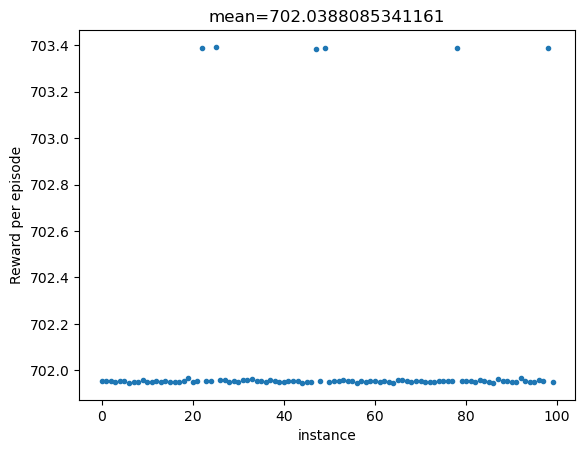

In [11]:
from matplotlib import pyplot as plt
Rewards = [eval_Q(Q,env) for i in range(100)]
plt.plot(Rewards,'.')
plt.title(f'mean={np.mean(Rewards)}')
plt.xlabel('instance')
plt.ylabel('Reward per episode')
plt.show()